## Settings

In [53]:
%cd /content/drive/MyDrive/Parkinson

/content/drive/MyDrive/Parkinson


In [2]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as tfl
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import class_weight 

In [3]:
# 39개 마커
MARKERS = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'LSHO', 'RSHO', 'CLAV', 'RBAK',
           'LUPA', 'RUPA', 'STRN', 'T10', 'LELB', 'RELB', 'LFRM', 'RFRM',
           'LWRA', 'RWRA', 'LWRB', 'RWRB', 'LFIN', 'RFIN', 'LASI', 'RASI',
           'LPSI', 'RPSI', 'LTHI', 'RTHI', 'LKNE', 'RKNE', 'LTIB', 'RTIB',
           'LANK', 'RANK', 'LTOE', 'RTOE', 'LHEE', 'RHEE']

### Configurations

In [108]:
# Data
DATAPATH = "./dataset"
CONTROL = os.path.join(DATAPATH, "Controls")
PD = os.path.join(DATAPATH, "PD")
TRAIN_DATA_PATH = DATAPATH + "_img"

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Model Parameters
HEIGHT = 300
WIDTH = 39
BATCH_SIZE = 2
MAX_EPOCH = 20
LEARNING_RATE = 3e-5
PATIENCE = 5

# Seed fixing
SEED = 42
np.random.seed(SEED)

## Data Loading

In [5]:
df_csv = pd.read_csv("csvinfo.csv")

In [6]:
df = df_csv.loc[df_csv['remove']==False,:]

In [7]:
print(f"Raw data : {len(df_csv)}")
print(f"Remove   : {df_csv['remove'].values.sum()}") # 결측값이 많아서 제외
print(f"Remaining: {len(df)}")

Raw data : 608
Remove   : 49
Remaining: 559


In [8]:
df['category'].value_counts()
# df['category'].value_counts(normalize=True)

PD          427
Controls    132
Name: category, dtype: int64

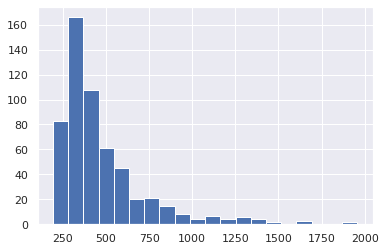

In [55]:
df['frame length'].hist(bins=20)

In [56]:
df.describe()

,frame length
count,559.000000
mean,476.078712
std,266.974857
min,192.000000
25%,306.000000
50%,387.000000
75%,547.000000
max,1957.000000


## Image Generator

In [109]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2,
    )

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    classes=['Controls', 'PD'],
    class_mode='binary',
    seed=SEED,
    subset='training')

test_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,  # same directory as training data
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    classes=['Controls', 'PD'],
    class_mode='binary',
    seed=SEED,
    subset='validation')

Found 448 images belonging to 2 classes.
Found 111 images belonging to 2 classes.


## CNN Model

In [110]:
model = tf.keras.models.Sequential([tfl.Conv2D(16, (3,3), (2,1), activation='relu', input_shape=(HEIGHT,WIDTH,3)),
                                    tfl.MaxPooling2D((2,2),(2,1)), 
                                    tfl.ZeroPadding2D(1),
                                    tfl.Conv2D(32, (3,3), (2,2), activation='relu'),
                                    tfl.GlobalAveragePooling2D(),
                                    # tfl.MaxPooling2D((2,2),(2,2)), 
                                    # tfl.Flatten(),
                                    # ------- RNN --------
                                    # tfl.RepeatVector(32),
                                    # tfl.Bidirectional(tfl.LSTM(16, return_sequences=True)),
                                    # tfl.Dropout(0.5),
                                    # tfl.Bidirectional(tfl.LSTM(16)),
                                    # tfl.Dropout(0.5),
                                    # tfl.Dense(1, activation='sigmoid'),
                                    # --------------------
                                    tfl.Dense(64, activation='relu'),
                                    tfl.Dropout(0.5),
                                    tfl.Dense(16, activation='relu'),
                                    tfl.Dropout(0.5),
                                    tfl.Dense(1, activation='sigmoid'),
                                    ])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 99, 37, 16)        448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 49, 36, 16)       0         
 g2D)                                                            
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 51, 38, 16)       0         
 ing2D)                                                          
                                                                 
 conv2d_29 (Conv2D)          (None, 25, 18, 32)        4640      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 12, 9, 32)        0         
 g2D)                                                            
                                                     

## Model Training

### Class weights

In [104]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes)

In [105]:
train_class_weights = dict(enumerate(class_weights))
train_class_weights  # 0: Controls, 1: PD

{0: 2.1132075471698113, 1: 0.6549707602339181}

### Train

In [111]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch=train_generator.samples // BATCH_SIZE,
                validation_data=test_generator, 
                validation_steps=test_generator.samples // BATCH_SIZE,
                class_weight=train_class_weights,
                epochs=MAX_EPOCH,
                callbacks=[EarlyStopping(monitor='loss', patience=PATIENCE)])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


224/224 [==============================] - 5s 20ms/step - loss: 0.6925 - accuracy: 0.5625 - val_loss: 0.6818 - val_accuracy: 0.7636
Epoch 2/20
224/224 [==============================] - 4s 19ms/step - loss: 0.6920 - accuracy: 0.6071 - val_loss: 0.6847 - val_accuracy: 0.7636
Epoch 3/20
224/224 [==============================] - 4s 19ms/step - loss: 0.6942 - accuracy: 0.5513 - val_loss: 0.6864 - val_accuracy: 0.7636
Epoch 4/20
224/224 [==============================] - 4s 19ms/step - loss: 0.6940 - accuracy: 0.5312 - val_loss: 0.6848 - val_accuracy: 0.7727
Epoch 5/20
224/224 [==============================] - 4s 19ms/step - loss: 0.6919 - accuracy: 0.5603 - val_loss: 0.6861 - val_accuracy: 0.7636
Epoch 6/20
224/224 [==============================] - 4s 19ms/step - loss: 0.6922 - accuracy: 0.5871 - val_loss: 0.6870 - val_accuracy: 0.7636
Epoch 7/20
224/224 [==============================] - 4s 19ms/step - loss: 0.6923 - accuracy: 0.5692 - val_loss: 0.6864 - val_accuracy: 0.7636
Epoch 8/20

### Result

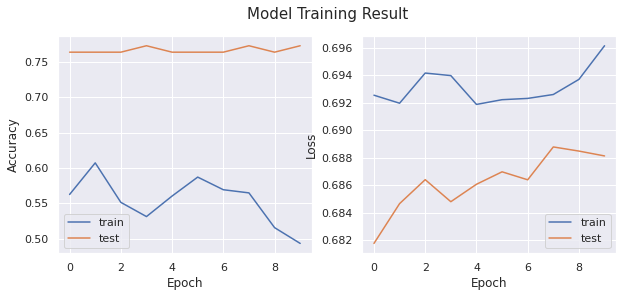

In [112]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.2)
sns.set_theme(style='darkgrid')
plt.suptitle('Model Training Result', fontsize=15)

max_epoch = len(history.history['accuracy'])
sns.lineplot(ax=axes[0], x=range(max_epoch), y=history.history["accuracy"], label='train')
sns.lineplot(ax=axes[0], x=range(max_epoch), y=history.history["val_accuracy"], label='test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')

sns.lineplot(ax=axes[1], x=range(max_epoch), y=history.history["loss"], label='train')
sns.lineplot(ax=axes[1], x=range(max_epoch), y=history.history["val_loss"], label='test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.show()

## Evalutate

In [113]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE )

print(f"Loss     : {test_loss:.4f}")
print(f"Accuracy : {test_acc:.4f}")

55/55 [==============================] - 1s 11ms/step - loss: 0.6883 - accuracy: 0.7636
Loss     : 0.6883
Accuracy : 0.7636


In [114]:
output = model.predict(test_generator)  # probability
output.shape

(111, 1)

### Confusion Matrix

In [ ]:
# tf.math.confusion_matrix(
#     labels= ,
#     predictions=output,
#     num_classes=2,
# )